In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from collections import Counter
import re
from tqdm.auto import tqdm
import time

# Cấu hình
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style('whitegrid')

# Paths
BASE_DIR = Path.cwd()
OUTPUT_DIR = BASE_DIR / "outputs" / "evaluation"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output sẽ được lưu tại: {OUTPUT_DIR}")

Output sẽ được lưu tại: d:\do-an-tot-nghiep\outputs\evaluation


c:\Users\kyen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Predictions & References

In [2]:
# Load predictions từ file compare
df = pd.read_csv("outputs/compare_results/predictions_compare.csv")

print(f"Loaded {len(df)} samples")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst row preview:")
print(df.head(1))

# Tách thành 2 dataframes cho 2 models
extractive_preds = pd.DataFrame({
    'input_text': df['document'],
    'reference': df['reference'],
    'prediction': df['pred_old'],
    'rouge_score': df['rougeL_old']
})

abstractive_preds = pd.DataFrame({
    'input_text': df['document'],
    'reference': df['reference'],
    'prediction': df['pred_new'],
    'rouge_score': df['rougeL_new']
})

print(f"\n✓ Extractive model (pred_old): {len(extractive_preds)} samples")
print(f"✓ Abstractive model (pred_new): {len(abstractive_preds)} samples")

Loaded 200 samples
Columns: ['id', 'document', 'reference', 'pred_old', 'pred_new', 'rougeL_old', 'rougeL_new', 'bert_old_f1', 'bert_new_f1']

First row preview:
   id                                           document  \
0   0  Trong ngày 8-9/7 , các thí_sinh đăng_ký tuyển_...   

                                           reference  \
0  Đề thi năng_khiếu Báo_chí của học_viện Báo_chí...   

                                            pred_old  \
0  Đây là năm thứ 5 liên_tiếp, AJC sử dụng hình_t...   

                                            pred_new  rougeL_old  rougeL_new  \
0  Trong ngày 8-9/7, các thí sinh đăng ký vào Học...    0.321244    0.345133   

   bert_old_f1  bert_new_f1  
0     0.693707     0.682794  

✓ Extractive model (pred_old): 200 samples
✓ Abstractive model (pred_new): 200 samples


## 2. ROUGE Scores Evaluation

In [3]:
from evaluate import load

rouge = load('rouge')

def compute_rouge(predictions, references):
    """Tính ROUGE scores"""
    results = rouge.compute(
        predictions=predictions,
        references=references,
        use_stemmer=False,
        use_aggregator=True
    )
    return {
        'rouge1': results['rouge1'] * 100,
        'rouge2': results['rouge2'] * 100,
        'rougeL': results['rougeL'] * 100,
        'rougeLsum': results['rougeLsum'] * 100,
    }

# Tính ROUGE cho cả 2 models
rouge_extractive = compute_rouge(
    extractive_preds['prediction'].tolist(),
    extractive_preds['reference'].tolist()
)

rouge_abstractive = compute_rouge(
    abstractive_preds['prediction'].tolist(),
    abstractive_preds['reference'].tolist()
)

print("\n=== ROUGE Scores ===")
print("\nExtractive Model:")
for metric, score in rouge_extractive.items():
    print(f"  {metric}: {score:.2f}")

print("\nAbstractive Model:")
for metric, score in rouge_abstractive.items():
    print(f"  {metric}: {score:.2f}")


=== ROUGE Scores ===

Extractive Model:
  rouge1: 50.47
  rouge2: 22.83
  rougeL: 30.64
  rougeLsum: 36.10

Abstractive Model:
  rouge1: 45.13
  rouge2: 22.18
  rougeL: 27.60
  rougeLsum: 34.57


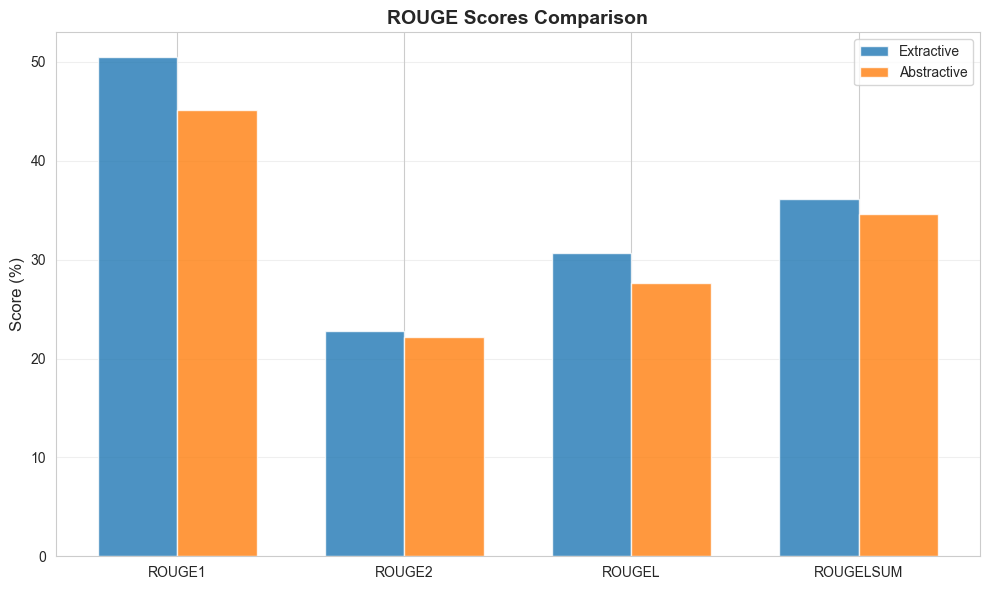


✓ Saved: d:\do-an-tot-nghiep\outputs\evaluation\rouge_comparison.png


In [4]:
# Visualize ROUGE scores comparison
rouge_df = pd.DataFrame({
    'Metric': list(rouge_extractive.keys()),
    'Extractive': list(rouge_extractive.values()),
    'Abstractive': list(rouge_abstractive.values())
})

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(rouge_df))
width = 0.35

ax.bar(x - width/2, rouge_df['Extractive'], width, label='Extractive', alpha=0.8)
ax.bar(x + width/2, rouge_df['Abstractive'], width, label='Abstractive', alpha=0.8)

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('ROUGE Scores Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(rouge_df['Metric'].str.upper())
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rouge_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'rouge_comparison.png'}")


=== BERT F1 Scores (Semantic Similarity) ===
Extractive Model (pred_old): 0.7133
Abstractive Model (pred_new): 0.6922

Δ BERT F1: -0.0210


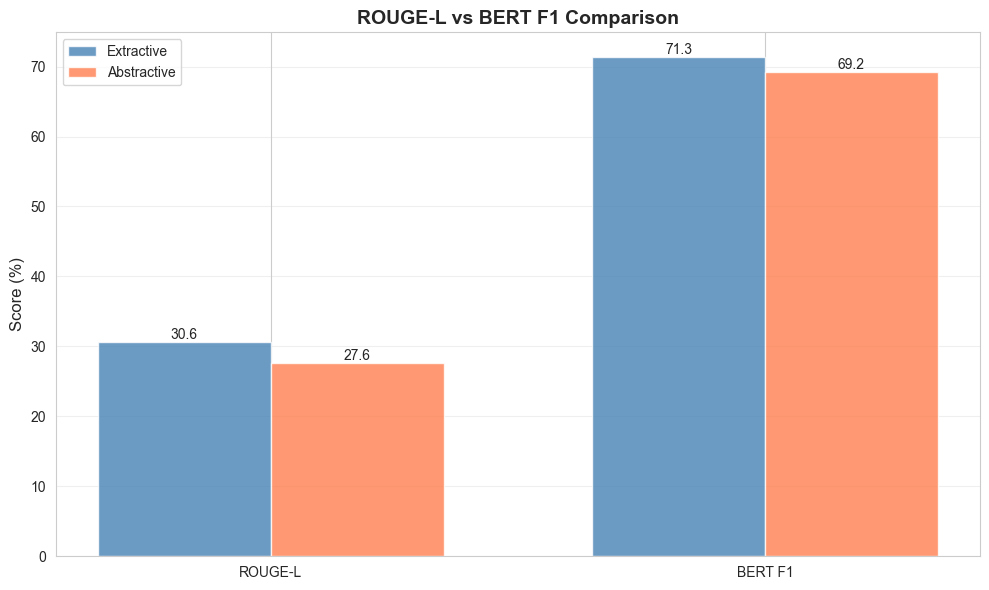


✓ Saved: d:\do-an-tot-nghiep\outputs\evaluation\rouge_bert_comparison.png


In [5]:
# File đã có sẵn BERT F1 scores
print("\n=== BERT F1 Scores (Semantic Similarity) ===")
print(f"Extractive Model (pred_old): {df['bert_old_f1'].mean():.4f}")
print(f"Abstractive Model (pred_new): {df['bert_new_f1'].mean():.4f}")
print(f"\nΔ BERT F1: {(df['bert_new_f1'].mean() - df['bert_old_f1'].mean()):.4f}")

# So sánh BERT F1 với ROUGE-L
comparison_df = pd.DataFrame({
    'Metric': ['ROUGE-L', 'BERT F1'],
    'Extractive': [
        extractive_preds['rouge_score'].mean() * 100,
        df['bert_old_f1'].mean() * 100
    ],
    'Abstractive': [
        abstractive_preds['rouge_score'].mean() * 100,
        df['bert_new_f1'].mean() * 100
    ]
})

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Extractive'], width, label='Extractive', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['Abstractive'], width, label='Abstractive', alpha=0.8, color='coral')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('ROUGE-L vs BERT F1 Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Thêm giá trị trên cột
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rouge_bert_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'rouge_bert_comparison.png'}")

### 2.1 BERT F1 Scores (Bonus Metric)

## 3. Length Analysis & Compression Ratio

In [6]:
def count_words(text):
    """Đếm số từ"""
    return len(str(text).split())

# Tính độ dài cho extractive
extractive_preds['input_len'] = extractive_preds['input_text'].apply(count_words)
extractive_preds['pred_len'] = extractive_preds['prediction'].apply(count_words)
extractive_preds['ref_len'] = extractive_preds['reference'].apply(count_words)
extractive_preds['compression_ratio'] = extractive_preds['pred_len'] / extractive_preds['input_len']

# Tính độ dài cho abstractive
abstractive_preds['input_len'] = abstractive_preds['input_text'].apply(count_words)
abstractive_preds['pred_len'] = abstractive_preds['prediction'].apply(count_words)
abstractive_preds['ref_len'] = abstractive_preds['reference'].apply(count_words)
abstractive_preds['compression_ratio'] = abstractive_preds['pred_len'] / abstractive_preds['input_len']

print("\n=== Length Statistics ===")
print("\nExtractive Model:")
print(f"  Input avg: {extractive_preds['input_len'].mean():.1f} words")
print(f"  Prediction avg: {extractive_preds['pred_len'].mean():.1f} words")
print(f"  Reference avg: {extractive_preds['ref_len'].mean():.1f} words")
print(f"  Compression ratio: {extractive_preds['compression_ratio'].mean():.3f}")

print("\nAbstractive Model:")
print(f"  Input avg: {abstractive_preds['input_len'].mean():.1f} words")
print(f"  Prediction avg: {abstractive_preds['pred_len'].mean():.1f} words")
print(f"  Reference avg: {abstractive_preds['ref_len'].mean():.1f} words")
print(f"  Compression ratio: {abstractive_preds['compression_ratio'].mean():.3f}")


=== Length Statistics ===

Extractive Model:
  Input avg: 405.8 words
  Prediction avg: 63.5 words
  Reference avg: 29.3 words
  Compression ratio: 0.197

Abstractive Model:
  Input avg: 405.8 words
  Prediction avg: 96.3 words
  Reference avg: 29.3 words
  Compression ratio: 0.292


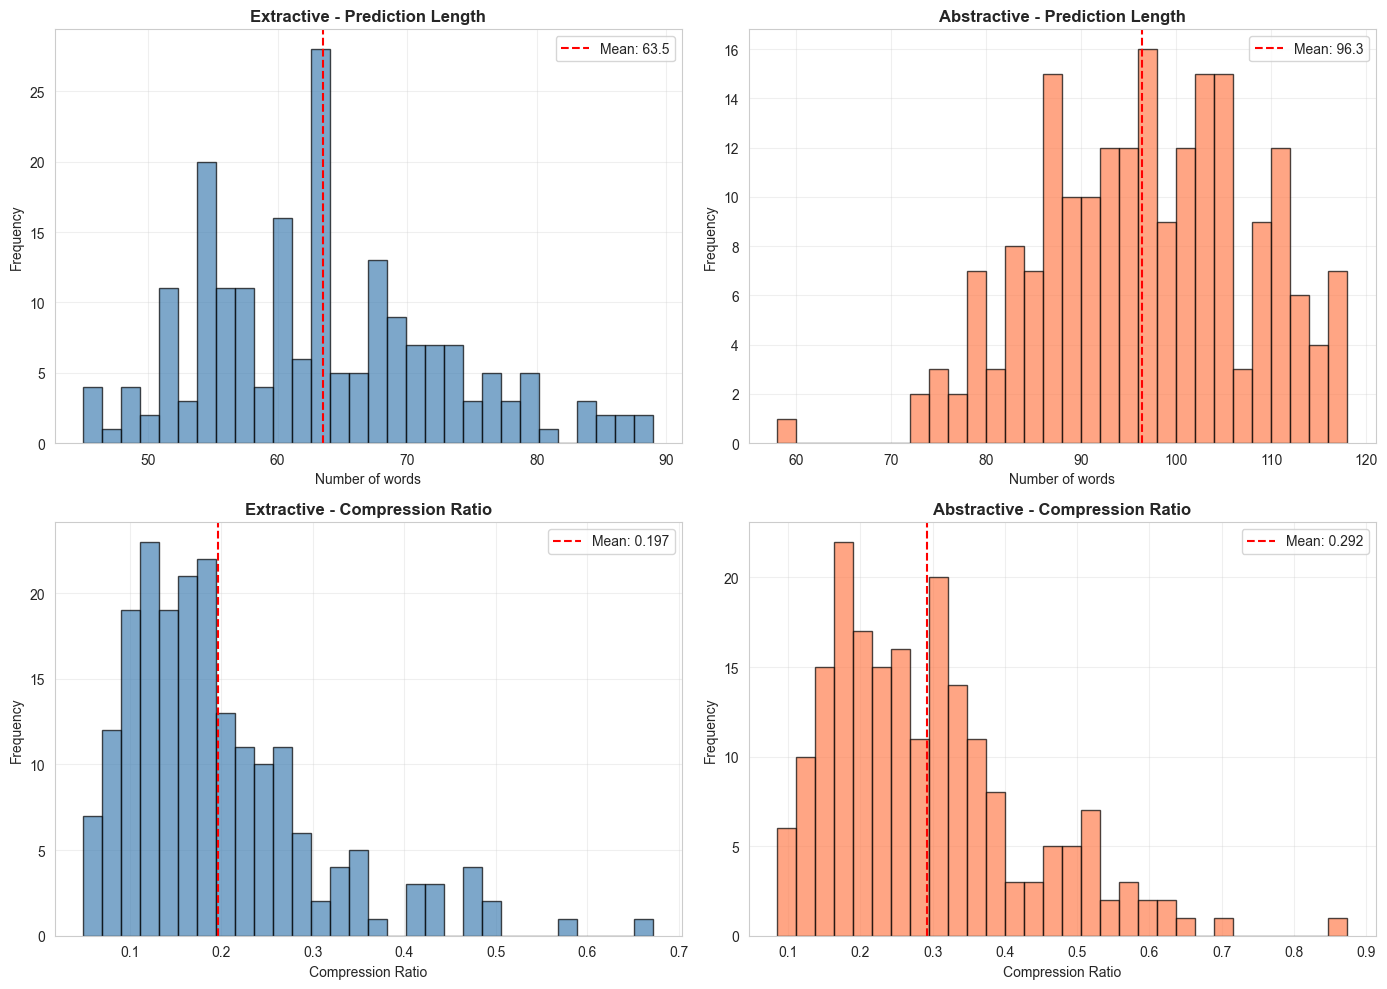


✓ Saved: d:\do-an-tot-nghiep\outputs\evaluation\length_analysis.png


In [7]:
# Visualize length distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extractive - Prediction length
axes[0, 0].hist(extractive_preds['pred_len'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(extractive_preds['pred_len'].mean(), color='red', linestyle='--', label=f"Mean: {extractive_preds['pred_len'].mean():.1f}")
axes[0, 0].set_title('Extractive - Prediction Length', fontweight='bold')
axes[0, 0].set_xlabel('Number of words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Abstractive - Prediction length
axes[0, 1].hist(abstractive_preds['pred_len'], bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].axvline(abstractive_preds['pred_len'].mean(), color='red', linestyle='--', label=f"Mean: {abstractive_preds['pred_len'].mean():.1f}")
axes[0, 1].set_title('Abstractive - Prediction Length', fontweight='bold')
axes[0, 1].set_xlabel('Number of words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Extractive - Compression ratio
axes[1, 0].hist(extractive_preds['compression_ratio'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(extractive_preds['compression_ratio'].mean(), color='red', linestyle='--', label=f"Mean: {extractive_preds['compression_ratio'].mean():.3f}")
axes[1, 0].set_title('Extractive - Compression Ratio', fontweight='bold')
axes[1, 0].set_xlabel('Compression Ratio')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Abstractive - Compression ratio
axes[1, 1].hist(abstractive_preds['compression_ratio'], bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].axvline(abstractive_preds['compression_ratio'].mean(), color='red', linestyle='--', label=f"Mean: {abstractive_preds['compression_ratio'].mean():.3f}")
axes[1, 1].set_title('Abstractive - Compression Ratio', fontweight='bold')
axes[1, 1].set_xlabel('Compression Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'length_analysis.png'}")

## 4. Repetition Analysis

In [8]:
def calculate_repetition_rate(text, n=2):
    """Tính tỷ lệ n-gram lặp lại"""
    words = str(text).split()
    if len(words) < n:
        return 0.0
    
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    if not ngrams:
        return 0.0
    
    unique_ngrams = len(set(ngrams))
    total_ngrams = len(ngrams)
    
    return 1.0 - (unique_ngrams / total_ngrams)

# Tính repetition cho bigrams và trigrams
extractive_preds['rep_bigram'] = extractive_preds['prediction'].apply(lambda x: calculate_repetition_rate(x, 2))
extractive_preds['rep_trigram'] = extractive_preds['prediction'].apply(lambda x: calculate_repetition_rate(x, 3))

abstractive_preds['rep_bigram'] = abstractive_preds['prediction'].apply(lambda x: calculate_repetition_rate(x, 2))
abstractive_preds['rep_trigram'] = abstractive_preds['prediction'].apply(lambda x: calculate_repetition_rate(x, 3))

print("\n=== Repetition Analysis ===")
print("\nExtractive Model:")
print(f"  Bigram repetition: {extractive_preds['rep_bigram'].mean():.3f}")
print(f"  Trigram repetition: {extractive_preds['rep_trigram'].mean():.3f}")

print("\nAbstractive Model:")
print(f"  Bigram repetition: {abstractive_preds['rep_bigram'].mean():.3f}")
print(f"  Trigram repetition: {abstractive_preds['rep_trigram'].mean():.3f}")


=== Repetition Analysis ===

Extractive Model:
  Bigram repetition: 0.010
  Trigram repetition: 0.000

Abstractive Model:
  Bigram repetition: 0.024
  Trigram repetition: 0.000


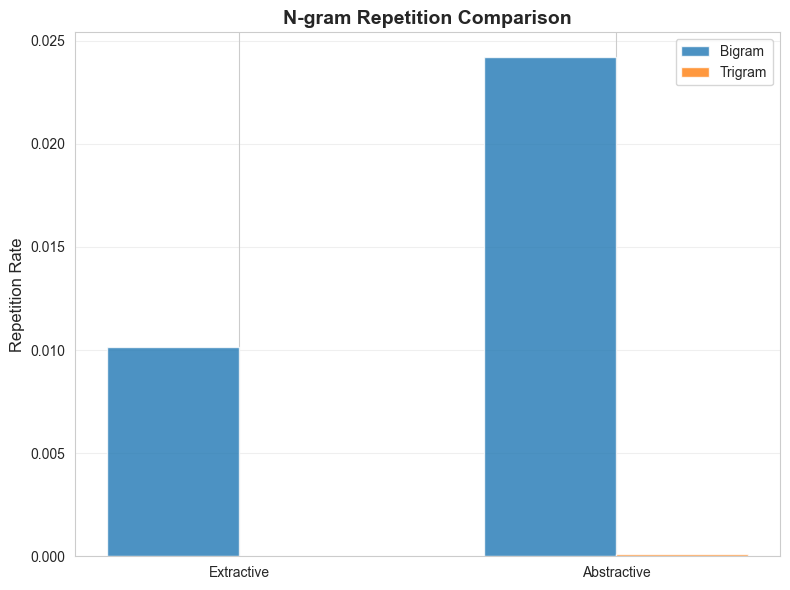


✓ Saved: d:\do-an-tot-nghiep\outputs\evaluation\repetition_analysis.png


In [9]:
# Visualize repetition rates
rep_data = pd.DataFrame({
    'Model': ['Extractive', 'Abstractive'],
    'Bigram': [extractive_preds['rep_bigram'].mean(), abstractive_preds['rep_bigram'].mean()],
    'Trigram': [extractive_preds['rep_trigram'].mean(), abstractive_preds['rep_trigram'].mean()]
})

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(rep_data))
width = 0.35

ax.bar(x - width/2, rep_data['Bigram'], width, label='Bigram', alpha=0.8)
ax.bar(x + width/2, rep_data['Trigram'], width, label='Trigram', alpha=0.8)

ax.set_ylabel('Repetition Rate', fontsize=12)
ax.set_title('N-gram Repetition Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(rep_data['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'repetition_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'repetition_analysis.png'}")

## 5. Qualitative Comparison - Best & Worst Examples

In [11]:
# ROUGE scores đã được tính sẵn trong file, chỉ cần hiển thị
print("✓ ROUGE scores already computed in the dataset!")
print(f"\nExtractive (pred_old) - Average ROUGE-L: {extractive_preds['rouge_score'].mean():.4f}")
print(f"Abstractive (pred_new) - Average ROUGE-L: {abstractive_preds['rouge_score'].mean():.4f}")

# Nếu muốn tính lại ROUGE đầy đủ cho toàn bộ dataset
print("\nRecalculating full ROUGE scores for comparison...")

def compute_rouge_single(prediction, reference):
    """Tính ROUGE cho 1 cặp prediction-reference"""
    result = rouge.compute(
        predictions=[prediction],
        references=[reference],
        use_stemmer=False
    )
    return result['rougeL']

✓ ROUGE scores already computed in the dataset!

Extractive (pred_old) - Average ROUGE-L: 0.3062
Abstractive (pred_new) - Average ROUGE-L: 0.2760

Recalculating full ROUGE scores for comparison...


In [12]:
# Lấy top 5 best và worst examples
def get_examples(df, n=5, best=True):
    """Lấy n examples tốt nhất hoặc tệ nhất"""
    sorted_df = df.sort_values('rouge_score', ascending=not best)
    return sorted_df.head(n)[['input_text', 'reference', 'prediction', 'rouge_score']]

# Extractive
ext_best = get_examples(extractive_preds, n=5, best=True)
ext_worst = get_examples(extractive_preds, n=5, best=False)

# Abstractive
abs_best = get_examples(abstractive_preds, n=5, best=True)
abs_worst = get_examples(abstractive_preds, n=5, best=False)

print("\n=== Best Examples (Extractive) ===")
print(ext_best[['rouge_score']].to_string())

print("\n=== Worst Examples (Extractive) ===")
print(ext_worst[['rouge_score']].to_string())

print("\n=== Best Examples (Abstractive) ===")
print(abs_best[['rouge_score']].to_string())

print("\n=== Worst Examples (Abstractive) ===")
print(abs_worst[['rouge_score']].to_string())


=== Best Examples (Extractive) ===
     rouge_score
187     0.586957
176     0.571429
27      0.552632
193     0.550898
199     0.530864

=== Worst Examples (Extractive) ===
     rouge_score
108     0.189781
92      0.196532
6       0.203209
15      0.204082
39      0.206061

=== Best Examples (Abstractive) ===
     rouge_score
138     0.470046
123     0.425287
185     0.372671
49      0.358209
97      0.352423

=== Worst Examples (Abstractive) ===
     rouge_score
102     0.181818
1       0.184971
81      0.187500
39      0.189474
125     0.190955


In [ ]:
# Tạo HTML file để compare examples
def create_comparison_html(ext_df, abs_df, output_path, title):
    """Tạo HTML table để so sánh examples"""
    html = f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>{title}</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }}
        h1 {{ color: #333; text-align: center; }}
        .example {{ background: white; margin: 20px 0; padding: 20px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
        .section {{ margin: 15px 0; }}
        .label {{ font-weight: bold; color: #555; margin-bottom: 5px; }}
        .text {{ background: #f9f9f9; padding: 10px; border-left: 3px solid #4CAF50; margin: 5px 0; line-height: 1.6; }}
        .score {{ color: #2196F3; font-weight: bold; }}
        .model-name {{ background: #2196F3; color: white; padding: 5px 15px; border-radius: 4px; display: inline-block; margin-bottom: 10px; }}
    </style>
</head>
<body>
    <h1>{title}</h1>
"""
    
    for idx in range(len(ext_df)):
        ext_row = ext_df.iloc[idx]
        abs_row = abs_df.iloc[idx]
        
        html += f"""
    <div class="example">
        <h2>Example {idx + 1}</h2>
        
        <div class="section">
            <div class="label">Input (first 500 chars):</div>
            <div class="text">{str(ext_row['input_text'])[:500]}...</div>
        </div>
        
        <div class="section">
            <div class="label">Reference:</div>
            <div class="text">{ext_row['reference']}</div>
        </div>
        
        <div class="section">
            <span class="model-name">Extractive Model</span>
            <div class="text">{ext_row['prediction']}</div>
            <div class="score">ROUGE-L: {ext_row['rouge_score']:.4f}</div>
        </div>
        
        <div class="section">
            <span class="model-name" style="background: #FF5722;">Abstractive Model</span>
            <div class="text">{abs_row['prediction']}</div>
            <div class="score">ROUGE-L: {abs_row['rouge_score']:.4f}</div>
        </div>
    </div>
"""
    
    html += """</body></html>"""
    
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html)
    
    print(f"✓ Saved: {output_path}")

# Tạo HTML cho best và worst examples
create_comparison_html(ext_best, abs_best, OUTPUT_DIR / 'best_examples.html', 'Top 5 Best Examples')
create_comparison_html(ext_worst, abs_worst, OUTPUT_DIR / 'worst_examples.html', 'Top 5 Worst Examples')

## 6. Training Curves Visualization

In [13]:
# Load training logs từ trainer_state.json
# Giả sử bạn có 2 files log từ 2 lần training

def load_training_logs(log_path):
    """Load và parse trainer_state.json"""
    with open(log_path, 'r') as f:
        data = json.load(f)
    
    log_history = data['log_history']
    
    train_loss = []
    eval_loss = []
    steps = []
    
    for entry in log_history:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            steps.append(entry['step'])
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
    
    return {'train_loss': train_loss, 'eval_loss': eval_loss, 'steps': steps}

# Load logs
try:
    ext_logs = load_training_logs('path/to/extractive/trainer_state.json')
    abs_logs = load_training_logs('path/to/abstractive/trainer_state.json')
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extractive
    axes[0].plot(ext_logs['steps'], ext_logs['train_loss'], label='Train Loss', alpha=0.7)
    axes[0].set_title('Extractive Model - Training Loss', fontweight='bold')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Abstractive
    axes[1].plot(abs_logs['steps'], abs_logs['train_loss'], label='Train Loss', alpha=0.7, color='coral')
    axes[1].set_title('Abstractive Model - Training Loss', fontweight='bold')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved: {OUTPUT_DIR / 'training_curves.png'}")
    
except FileNotFoundError:
    print("⚠ Training log files not found. Skip this section.")

⚠ Training log files not found. Skip this section.


## 7. Inference Time Comparison

In [16]:
# Benchmark inference time
# Chú ý: Cần load models trước

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load models
print("\nLoading models...")
ext_tokenizer = AutoTokenizer.from_pretrained('D:\do-an-tot-nghiep\models/best_model_combined')
ext_model = AutoModelForSeq2SeqLM.from_pretrained('D:\do-an-tot-nghiep\models/best_model_combined').to(device)

abs_tokenizer = AutoTokenizer.from_pretrained('D:\do-an-tot-nghiep\models/final_vit5_model_phase2')
abs_model = AutoModelForSeq2SeqLM.from_pretrained('D:\do-an-tot-nghiep\models/final_vit5_model_phase2').to(device)
print("✓ Models loaded!")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Using device: cuda

Loading models...
✓ Models loaded!
✓ Models loaded!


In [20]:
def measure_inference_time(model, tokenizer, texts, device, num_samples=20):
    """Đo thời gian inference trung bình - chỉ test 20 samples để nhanh"""
    model.eval()
    times = []
    
    # Warmup
    with torch.no_grad():
        inputs = tokenizer(texts[0], return_tensors='pt', max_length=1280, truncation=True).to(device)
        _ = model.generate(**inputs, max_new_tokens=258)
    
    print(f"Testing on {num_samples} samples...")
    # Measure
    for text in tqdm(texts[:num_samples], desc="Measuring"):
        start = time.time()
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', max_length=1280, truncation=True).to(device)
            _ = model.generate(**inputs, max_new_tokens=258, num_beams=5)
        end = time.time()
        times.append(end - start)
    
    return np.mean(times), np.std(times)

# Measure inference time (chỉ 20 samples thay vì 100)
test_texts = extractive_preds['input_text'].tolist()

print("\nMeasuring Extractive model...")
ext_mean, ext_std = measure_inference_time(ext_model, ext_tokenizer, test_texts, device, num_samples=20)

print("\nMeasuring Abstractive model...")
abs_mean, abs_std = measure_inference_time(abs_model, abs_tokenizer, test_texts, device, num_samples=20)

print("\n=== Inference Time Comparison ===")
print(f"Extractive: {ext_mean:.3f} ± {ext_std:.3f} seconds/sample")
print(f"Abstractive: {abs_mean:.3f} ± {abs_std:.3f} seconds/sample")


Measuring Extractive model...
Testing on 20 samples...
Testing on 20 samples...


Measuring: 100%|██████████| 20/20 [06:49<00:00, 20.46s/it]




Measuring Abstractive model...
Testing on 20 samples...
Testing on 20 samples...


Measuring: 100%|██████████| 20/20 [03:39<00:00, 10.97s/it]


=== Inference Time Comparison ===
Extractive: 20.456 ± 17.258 seconds/sample
Abstractive: 10.967 ± 9.781 seconds/sample


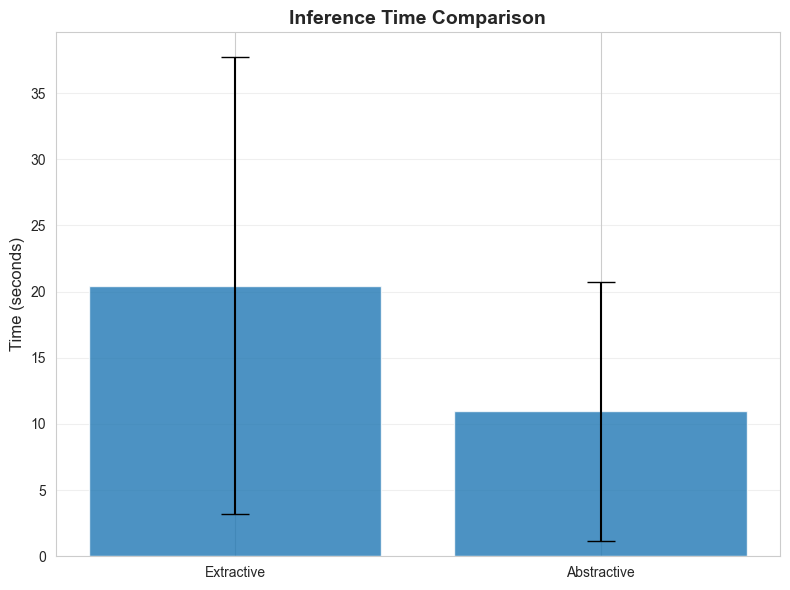


✓ Saved: d:\do-an-tot-nghiep\outputs\evaluation\inference_time.png


In [21]:
# Visualize inference time
time_data = pd.DataFrame({
    'Model': ['Extractive', 'Abstractive'],
    'Mean Time': [ext_mean, abs_mean],
    'Std': [ext_std, abs_std]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(time_data['Model'], time_data['Mean Time'], yerr=time_data['Std'], capsize=10, alpha=0.8)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'inference_time.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'inference_time.png'}")

## 8. Summary Report

In [22]:
# Tạo summary report
summary = f"""
==============================================
     EVALUATION SUMMARY REPORT
==============================================

Dataset Size: {len(extractive_preds)} samples

--- ROUGE Scores ---
Extractive Model:
  ROUGE-1: {rouge_extractive['rouge1']:.2f}
  ROUGE-2: {rouge_extractive['rouge2']:.2f}
  ROUGE-L: {rouge_extractive['rougeL']:.2f}

Abstractive Model:
  ROUGE-1: {rouge_abstractive['rouge1']:.2f}
  ROUGE-2: {rouge_abstractive['rouge2']:.2f}
  ROUGE-L: {rouge_abstractive['rougeL']:.2f}

--- Length Statistics ---
Extractive Model:
  Avg prediction length: {extractive_preds['pred_len'].mean():.1f} words
  Compression ratio: {extractive_preds['compression_ratio'].mean():.3f}

Abstractive Model:
  Avg prediction length: {abstractive_preds['pred_len'].mean():.1f} words
  Compression ratio: {abstractive_preds['compression_ratio'].mean():.3f}

--- Repetition Analysis ---
Extractive Model:
  Bigram repetition: {extractive_preds['rep_bigram'].mean():.3f}
  Trigram repetition: {extractive_preds['rep_trigram'].mean():.3f}

Abstractive Model:
  Bigram repetition: {abstractive_preds['rep_bigram'].mean():.3f}
  Trigram repetition: {abstractive_preds['rep_trigram'].mean():.3f}

--- Inference Time ---
Extractive: {ext_mean:.3f} ± {ext_std:.3f} sec/sample
Abstractive: {abs_mean:.3f} ± {abs_std:.3f} sec/sample

==============================================
All outputs saved to: {OUTPUT_DIR}
==============================================
"""

print(summary)

# Save to file
with open(OUTPUT_DIR / 'summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"\n✓ Saved: {OUTPUT_DIR / 'summary_report.txt'}")


     EVALUATION SUMMARY REPORT

Dataset Size: 200 samples

--- ROUGE Scores ---
Extractive Model:
  ROUGE-1: 50.47
  ROUGE-2: 22.83
  ROUGE-L: 30.64

Abstractive Model:
  ROUGE-1: 45.13
  ROUGE-2: 22.18
  ROUGE-L: 27.60

--- Length Statistics ---
Extractive Model:
  Avg prediction length: 63.5 words
  Compression ratio: 0.197

Abstractive Model:
  Avg prediction length: 96.3 words
  Compression ratio: 0.292

--- Repetition Analysis ---
Extractive Model:
  Bigram repetition: 0.010
  Trigram repetition: 0.000

Abstractive Model:
  Bigram repetition: 0.024
  Trigram repetition: 0.000

--- Inference Time ---
Extractive: 20.456 ± 17.258 sec/sample
Abstractive: 10.967 ± 9.781 sec/sample

All outputs saved to: d:\do-an-tot-nghiep\outputs\evaluation


✓ Saved: d:\do-an-tot-nghiep\outputs\evaluation\summary_report.txt


## Done!

Các file đã tạo:
1. `rouge_comparison.png` - So sánh ROUGE scores
2. `length_analysis.png` - Phân tích độ dài và compression ratio
3. `repetition_analysis.png` - Phân tích n-gram repetition
4. `best_examples.html` - Top 5 examples tốt nhất
5. `worst_examples.html` - Top 5 examples tệ nhất
6. `training_curves.png` - Đồ thị training loss
7. `inference_time.png` - So sánh thời gian inference
8. `summary_report.txt` - Báo cáo tổng kết